In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle

In [ ]:
def load_data(file_path):
  file = open(file_path, 'r')
  sentences = []
  arr = []
  for line in file:
    line = line.strip("\n").split("\t")
    if len(line) > 1:
      word = line[0]
      label = line[1]
      if(label != 'O'):
          label = line[1] + "_Disease"
      arr.append((word, label))
        
    if len(line) == 1:
      sentences.append(arr)
      arr = []
          
  file.close()
  return sentences

In [ ]:
sentences = load_data("drive/MyDrive/ner1/train.tsv")
x= load_data("drive/MyDrive/ner1/test.tsv")
y= load_data("drive/MyDrive/ner1/train_dev.tsv")
for z in x:
  sentences.append(z)
for z in y:
  sentences.append(z)

In [ ]:
unique_list = []
seen_sublists = set()

for sublist in sentences:
    if tuple(sublist) not in seen_sublists:
        unique_list.append(sublist)
        seen_sublists.add(tuple(sublist))

# print(len(unique_list))
sentences = unique_list

In [ ]:
words = []
tags = []
for x in sentences:
  for y in x:
    words.append(y[0])
    tags.append(y[1])

words.append("ENDPAD")
words = list(set(words))
tags = list(set(tags))
num_words = len(words)
num_tags = len(tags)
print(len(sentences))

13893


In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {'O': 0, 'B_Disease': 1, 'I_Disease': 2}

In [ ]:
# Save the word2idx dictionary
# with open("drive/MyDrive/word2idx_1.pkl", "wb") as file:
#     pickle.dump(word2idx, file)

In [ ]:
# from google.colab import files

# # Download a file from session storage
# files.download("word2idx.pkl")

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# print(x_test)

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [ ]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            869050    
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 3)            603       
 ibuted)                                                         
                                                             

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

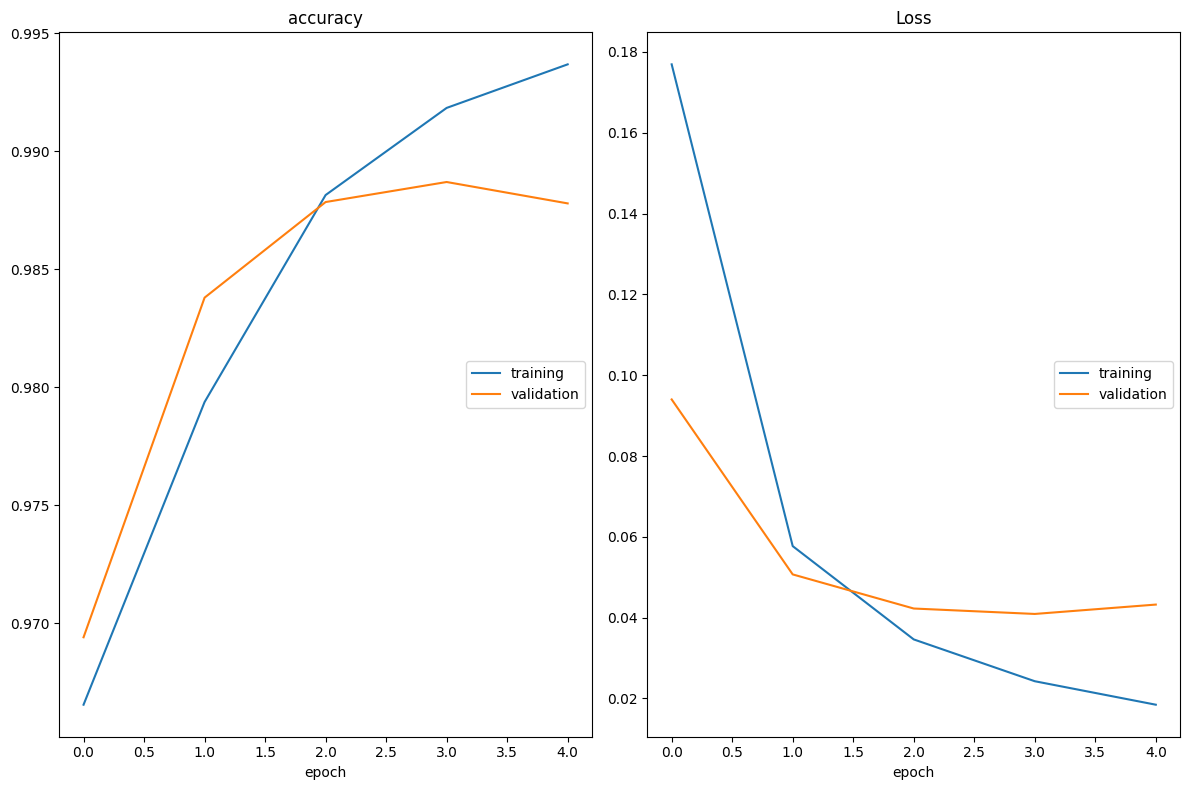

accuracy
	training         	 (min:    0.967, max:    0.994, cur:    0.994)
	validation       	 (min:    0.969, max:    0.989, cur:    0.988)
Loss
	training         	 (min:    0.018, max:    0.177, cur:    0.018)
	validation       	 (min:    0.041, max:    0.094, cur:    0.043)

Epoch 5: val_loss did not improve from 0.04091
174/174 [==============================] - 69s 395ms/step - loss: 0.0185 - accuracy: 0.9937 - val_loss: 0.0432 - val_accuracy: 0.9878


In [ ]:
chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=64, 
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
model.evaluate(x_test, y_test)

87/87 [==============================] - 4s 41ms/step - loss: 0.0432 - accuracy: 0.9878


[0.043232955038547516, 0.9877941608428955]

In [ ]:
import re

def clean_text(text):
    text = re.sub(r"[^a-zA-Z ]", "", text)
    text = text.lower()
    return text

In [ ]:
example_text = "i have malaria."
example_text = clean_text(example_text)
example_words = example_text.split()
example_indices = [word2idx.get(word, 0) for word in example_words]  # Convert words to indices
# print(example_indices)
example_padded = pad_sequences([example_indices], maxlen=max_len, padding="post", value=num_words-1)
# print(word2idx)
# print(num_words-1)
prediction = model.predict(example_padded)
predicted_labels = np.argmax(prediction, axis=-1)[0]  # Get predicted labels for the first example
# print(model)
for i in range(len(example_words)):
  print(predicted_labels[i])

1/1 [==============================] - 0s 45ms/step
0
0
1


In [ ]:
# model.save("./drive/MyDrive/ner_lstm_1")